In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
from scipy.stats import pearsonr
from scipy.spatial import distance
# from scipy.spatial
from scipy.stats.mstats import gmean
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess 
from skmisc.loess import loess
%matplotlib inline
from itertools import combinations
from itertools import chain
from itertools import product
import statsmodels
from sklearn.manifold import TSNE
import umap

from adjustText import adjust_text

from multiprocessing import Pool
import sys
import os
import copy
sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

# fgm_simulation_path = '/Users/grantkinsler/Documents/Stanford/Research/StarryNight/Git/starry-night/Simulations/FGM_simulation_callable.py'
# sys.path.append(os.path.dirname(os.path.expanduser(fgm_simulation_path)))
# from FGM_simulation_callable import simulation, nball_pull, gaussian_fitness

tools_path = '../code/tools.py'
graphs_path = '../code/graphs.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
sys.path.append(os.path.dirname(os.path.expanduser(graphs_path)))
import tools
import graphs
from tools import mutant_colorset
from tools import condition_colorset
from tools import renamed_conditions

In [3]:
fitness_data = p.read_csv('../data/fitness_weighted_allconditions_swapsremoved.csv')

sorted_m3_cols =   ['M3_Batch_23_fitness', '19_fitness', 'M3_Batch_18_fitness',
       'M3_Batch_20_fitness', 'M3_Batch_3_fitness', 'M3_Batch_13_fitness',
       'M3_Batch_6_fitness', '1BB_M3_fitness', 'M3_Batch_21_fitness']

sorted_nonm3_cols = ['1BB_1.4%Gluc_fitness', 'Ferm_44hr_Transfer_fitness',
       '1BB_1%Gly_fitness', '1BB_1.8%Gluc_fitness', '1BB_0.5%Raf_fitness',
       'Geldanamycin8.5uM_fitness', 'Ferm_40hr_Transfer_fitness',
       '1BB_Baffle_fitness', '1.5%_fitness', 'DMSO_fitness',
       '1BB_1%Raf_fitness', '1.7%_fitness', '1.6%_fitness',
       'Ferm_50hr_Transfer_fitness', '1.4%_fitness', '1BB_2ugFlu_fitness',
       'Ferm_54hr_Transfer_fitness', 'Resp_3Day_Transfer_fitness',
       '1BB_17uMGdA_fitness', '1.8%_fitness',
       'Resp_24hr_Transfer_fitness', '1BB_1%EtOH_fitness',
       '1BB_8.5uMGdA_fitness', '1BB_SucRaf_fitness', '2.5%_fitness',
       'Resp_4Day_Transfer_fitness', 'Resp_5Day_Transfer_fitness',
       '1BB_0.2MNaCl_fitness', '1BB_0.2MKCl_fitness',
       '1BB_0.5ugFlu_fitness', 'Ben0.4_fitness', 'Ben2_fitness',
       'Resp_6Day_Transfer_fitness', 'Resp_7Day_Transfer_fitness',
       '1BB_0.5MKCl_fitness', '1BB_0.5MNaCl_fitness']

first_nonsubtle = 16


There are two things we can do to assess how robust the conclusion that the extra 5 components represent real signal.

(1) We can permute the values of all the mutants (and conditions?) in the 5-9 components. If it's true that just having extra dimensions to play with increases predictive power, then there should be an improvement in the new conditions here.

(2) We can change the specific mutants that are in our training and testing sets - if this structure is specific to these mutants, then the signal we see should change. Similarly, we can slightly alter the composition of these sets (slightly more or fewer mutants per gene) to see if this qualitatively changes our results.

## Permuting latent components

1 0.4879196479746096
2 0.7518631703428433
3 0.7563027521960458
4 0.7562133181831945
5 0.7530341505749277
6 0.7747923759532117
7 0.7719507701046795
8 0.8052986993354914
9 0.8051505648840848
10 0.8073018024117058
11 0.8045415961477089
12 0.784604831944834
13 0.7716965264767164
14 0.7500714377286755
15 0.7641089720792369
16 0.7612589071932062
17 0.7381383255768643
18 0.755708881517503
19 0.7465078895562913
20 0.7444874574563376
21 0.7154762678381292
22 0.6913760154643998
23 0.6492888653625544
24 0.511797662285502
25 0.4430479671272902
0.0003910346582242956 0.0002646158693469664 0.6767069459996151
9
1 0.49935031887185855
2 0.7465771965043633
3 0.7476422389388804
4 0.7523872340009754
5 0.7484175059915779
6 0.7769148858211481
7 0.7837846734909206
8 0.8098561026839498
9 0.7961335960166737
10 0.8066726108067298
11 0.8067313241785784
12 0.7957945896779672
13 0.7956194481377323
14 0.7925940465118212
15 0.7955804877903379
16 0.788297888371349
17 0.7917194597588684
18 0.7895950651059015
19 0.78583

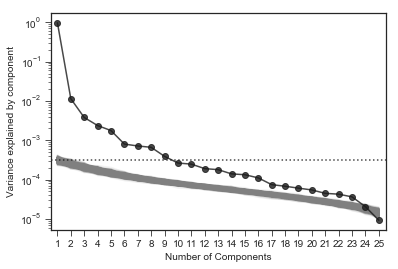

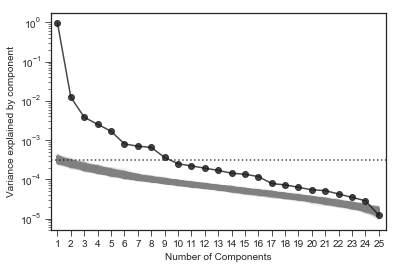

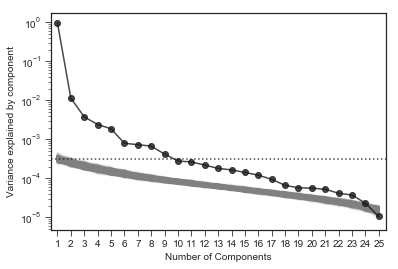

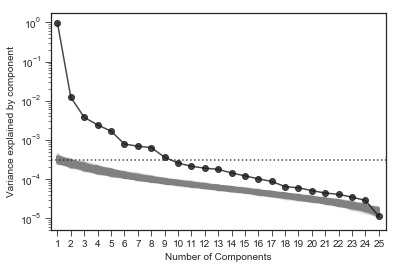

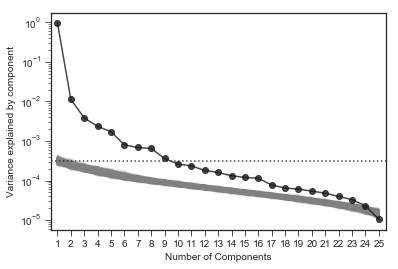

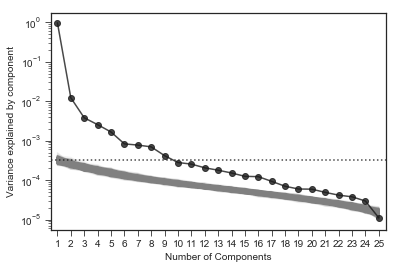

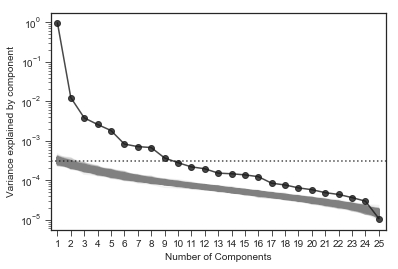

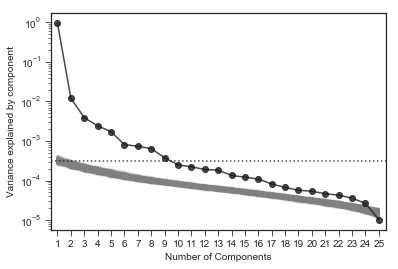

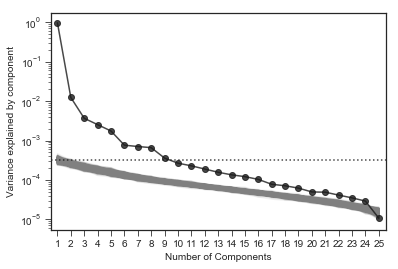

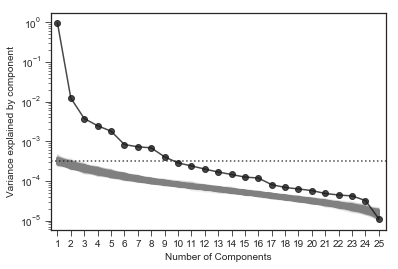

In [7]:
this_data = fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()
this_data = this_data.sort_values('barcode')

datasets = {}


gene_list = ['IRA1_nonsense','GPB2','PDE2','Diploid','ExpNeutral']

n_trials = 10
for i in range(n_trials):
    
    max_train = 4
    max_test = 10
    
    training_bcs, testing_bcs = tools.select_train_test_mutants(this_data,max_train=max_train,max_test=max_test)
    
    datasets[i] = tools.situate_data(this_data,list(sorted_m3_cols) + list(sorted_nonm3_cols[:first_nonsubtle]),list(sorted_nonm3_cols[first_nonsubtle:]),
                  training_bcs,testing_bcs,gene_list,fixed_mutant_sets=True)
    
    plt.figure()
    ax = plt.subplot(111)

    these_cols = list(sorted_m3_cols) + list(sorted_nonm3_cols[:first_nonsubtle])

    this_fitness = this_data[this_data['barcode'].isin(list(training_bcs)+list(testing_bcs))][these_cols].values
    
    this_error = this_data[this_data['barcode'].isin(list(training_bcs)+list(testing_bcs))][[col.replace('_fitness','_error') for col in these_cols ]].values

    tools.svd_noise_comparison_figure(ax,this_fitness,this_error,1000,yscale='log')




4 0.6995003277918794
9 0.6907695310957808
4 0.6938394713825398
9 0.6903173952584878
4 0.685114357622292
9 0.7039430790086909
4 0.5375155148999242
9 0.620234789563438
4 0.6875746975962318
9 0.7309455156399587
4 0.6762901634532403
9 0.7090805537247679
4 0.7075126835406851
9 0.7071943399838247
4 0.685257254593292
9 0.7357175487773939
4 0.6795456309336492
9 0.7222714925432252
4 0.5819625903477103
9 0.6385251191592767


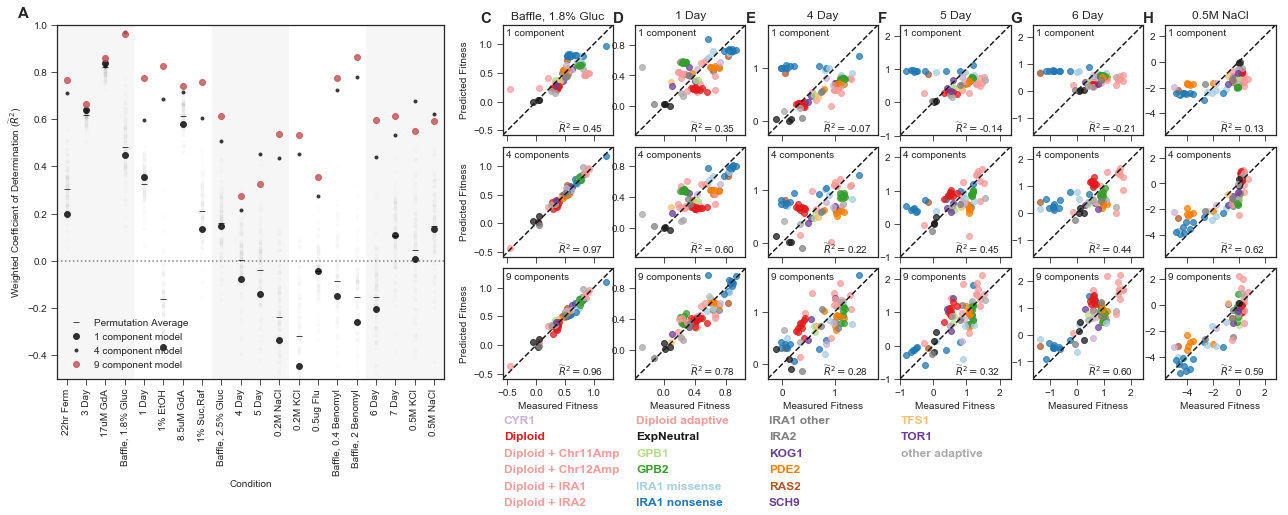

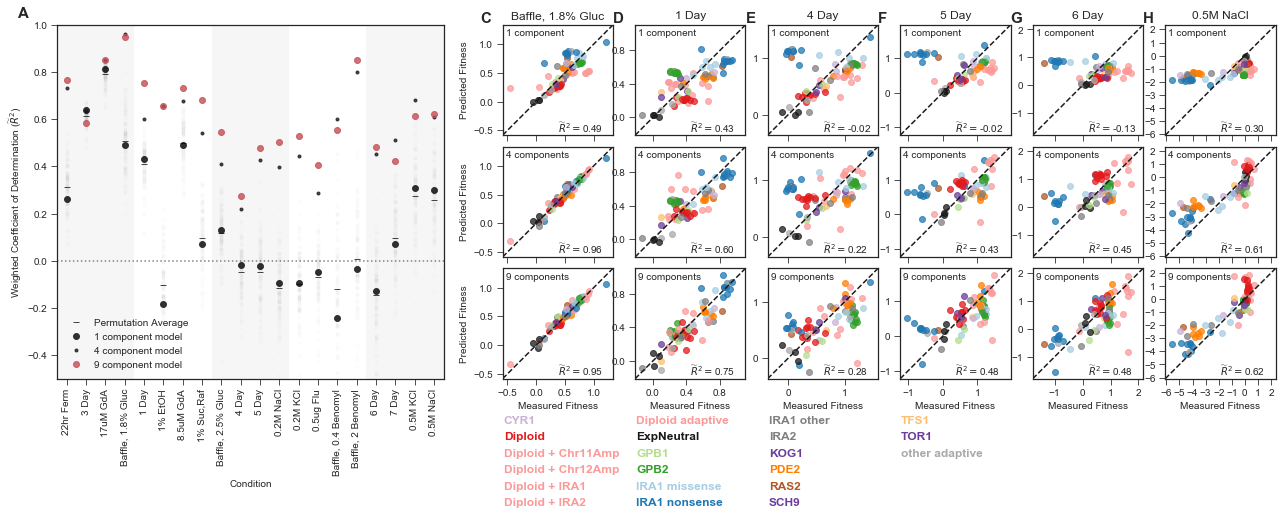

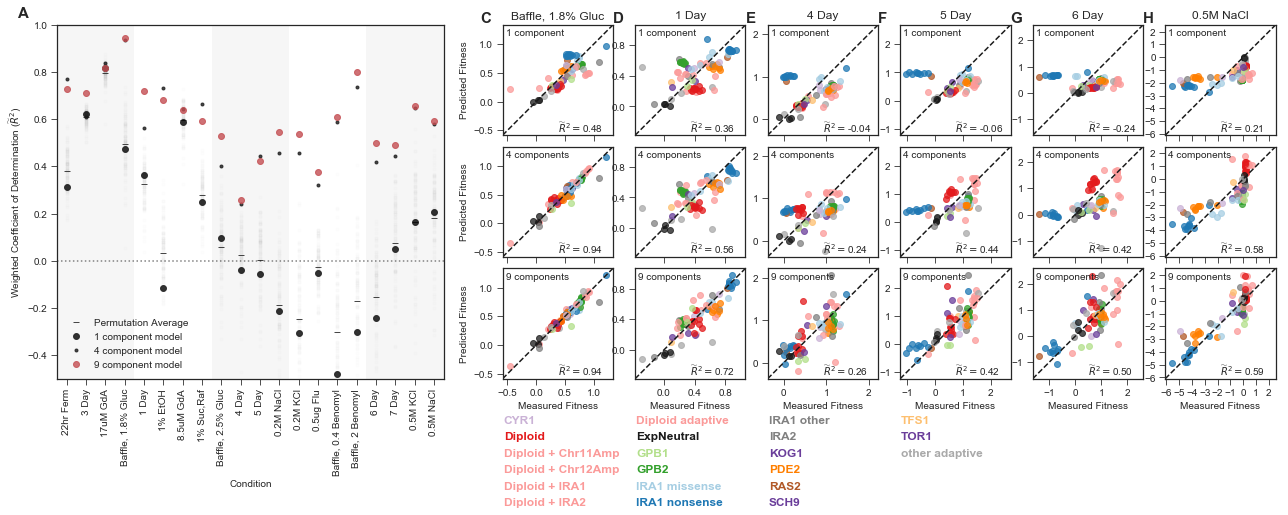

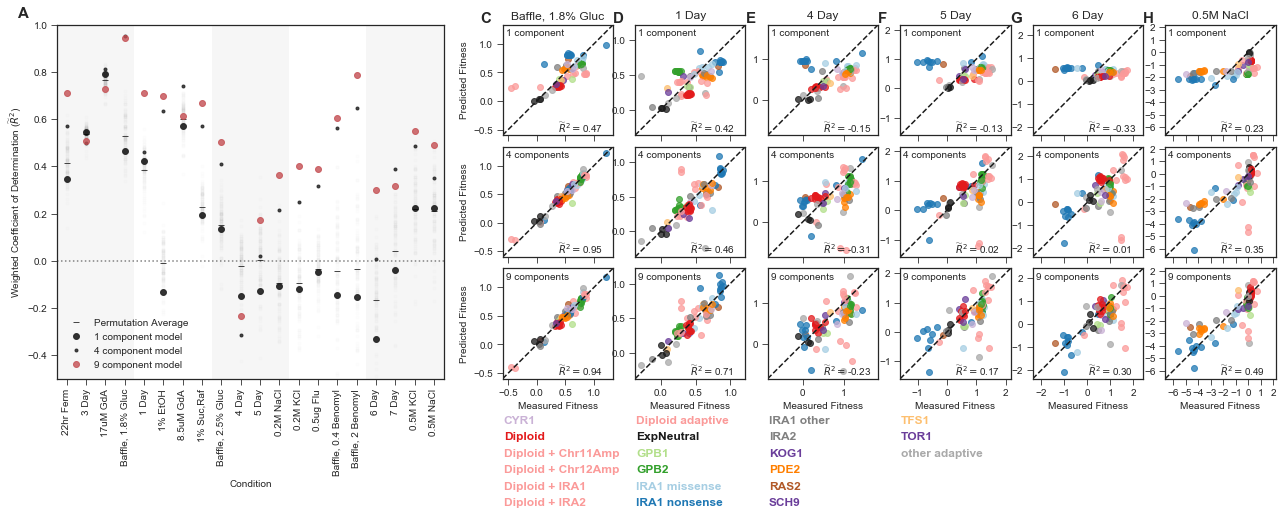

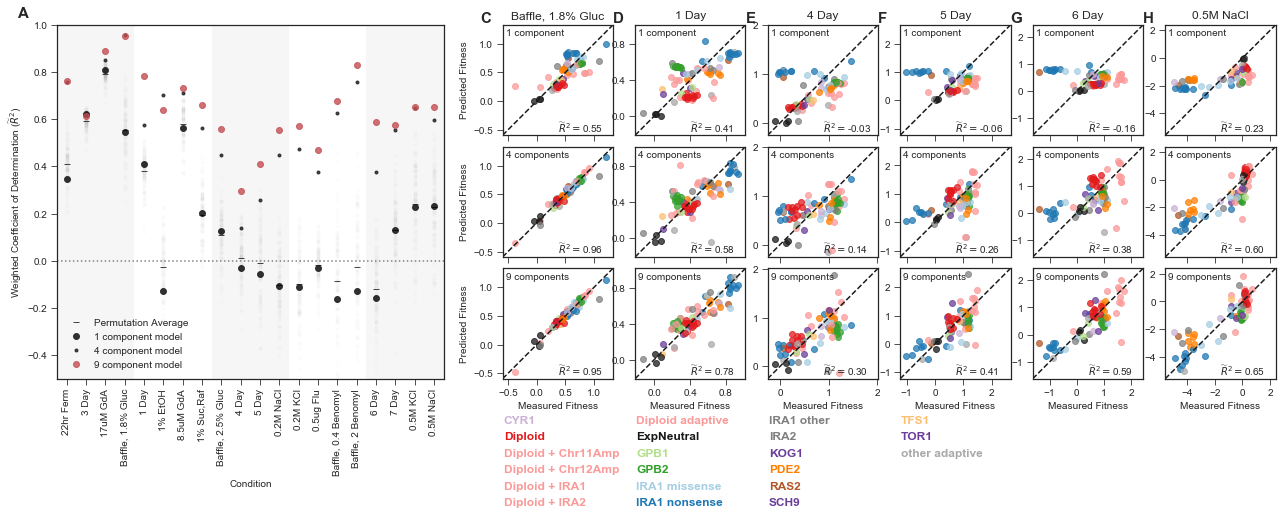

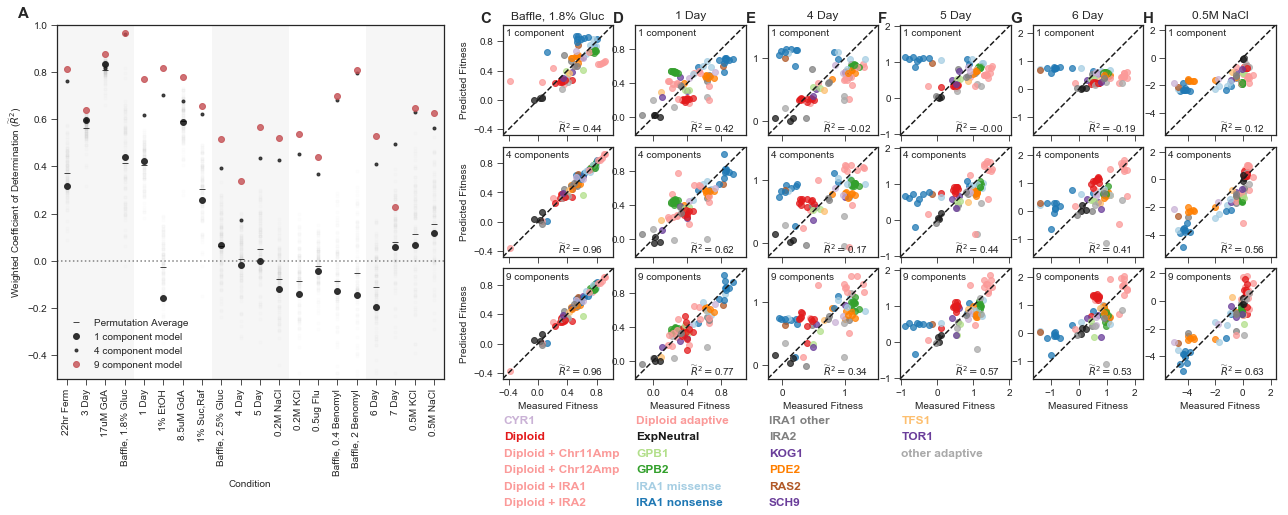

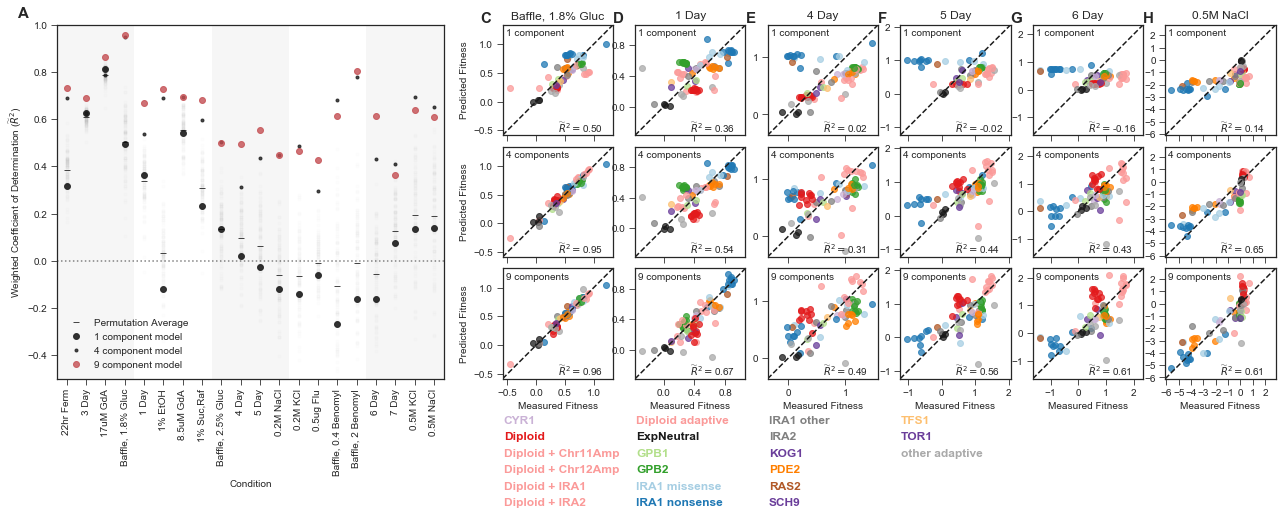

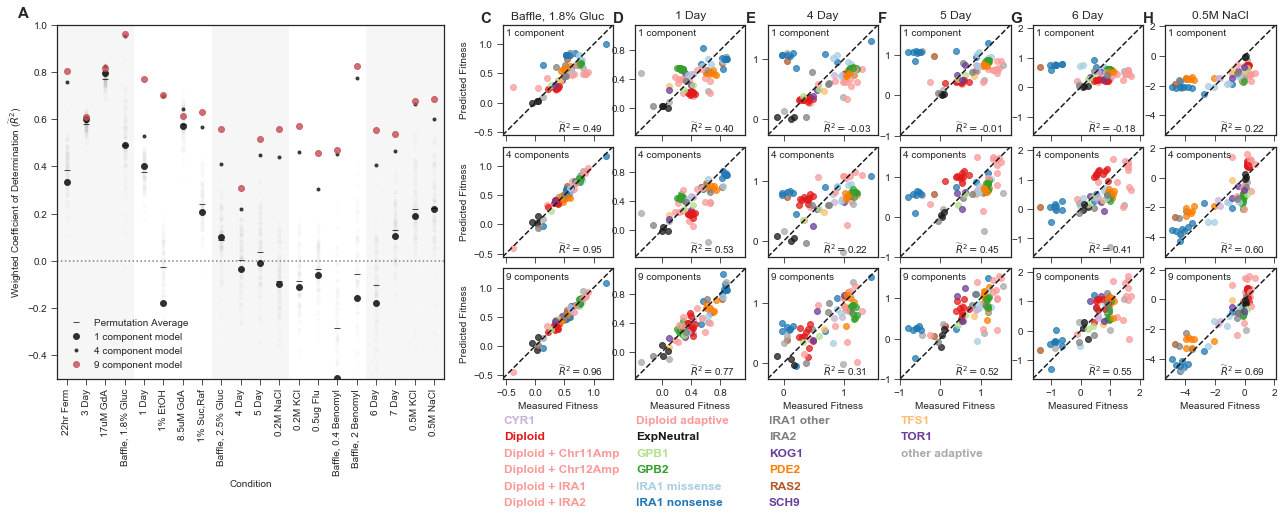

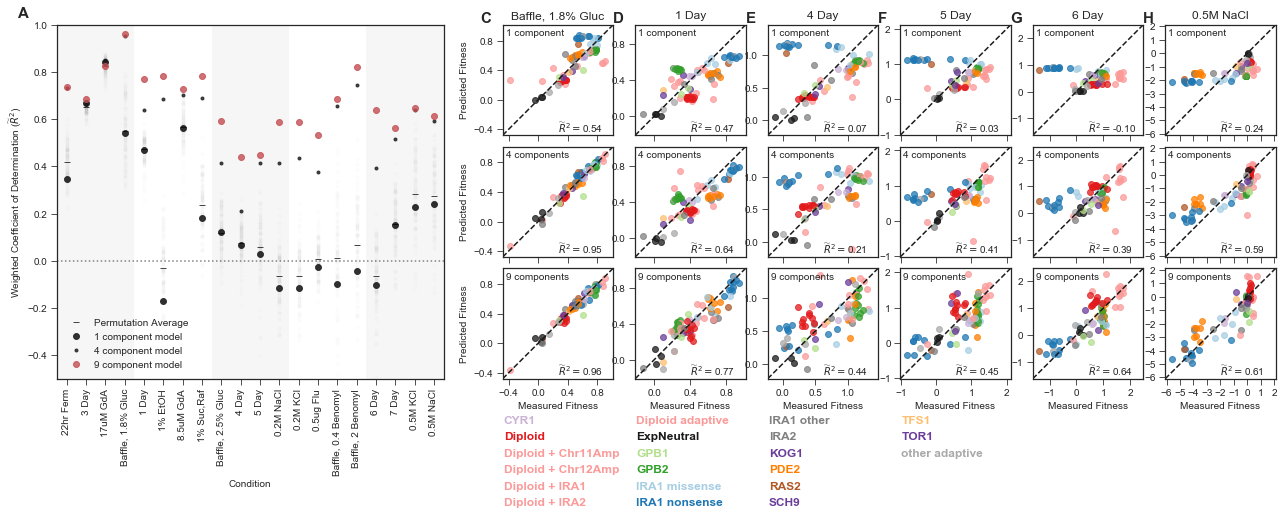

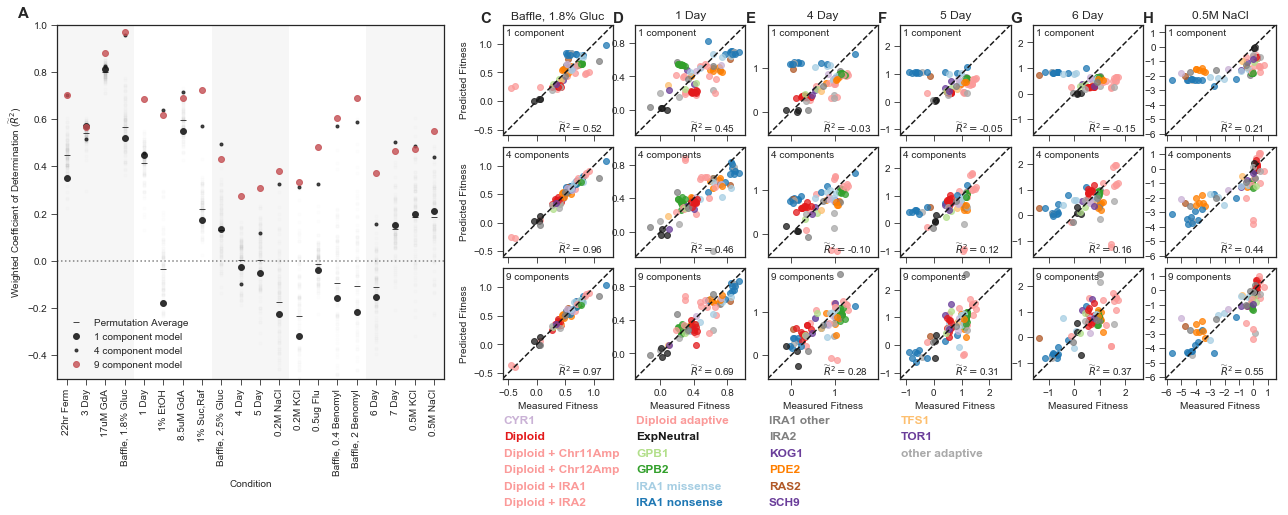

In [10]:
for i in range(n_trials):
#     example_names = ['1.8%','Resp_24hr_Transfer','1BB_1%EtOH','Ben2','1BB_0.5MNaCl']
#     # graphs.Figure4_w_examples(datasets['batch_to_nonbatch_wothers_fixed_mutants'],gene_list,this_data,[col + '_fitness' for col in example_names],model=4)
#     interesting_conditions = ['Resp_24hr_Transfer_fitness','1BB_SucRaf_fitness','2.5%_fitness','Resp_4Day_Transfer_fitness', '1BB_0.5ugFlu_fitness','Resp_6Day_Transfer_fitness']
#     example_names = ['1.8%','Resp_24hr_Transfer','1BB_SucRaf','2.5%','Resp_4Day_Transfer', '1BB_0.5ugFlu','Resp_6Day_Transfer','1BB_0.5MNaCl']
    example_names = ['1.8%','Resp_24hr_Transfer','Resp_4Day_Transfer','Resp_5Day_Transfer','Resp_6Day_Transfer','1BB_0.5MNaCl']
    
    graphs.Figure4_w_examples(datasets[i],gene_list,this_data,[col + '_fitness' for col in example_names],models=[3,8],weighted=True)
# plt.savefig(f'Figure4_with_prediction_examples_unweighted.pdf',bbox_inches='tight')

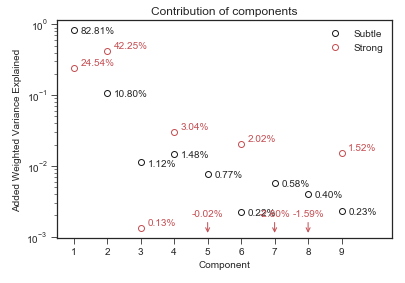

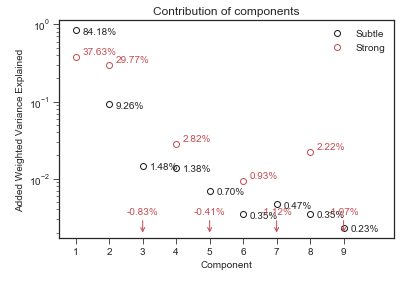

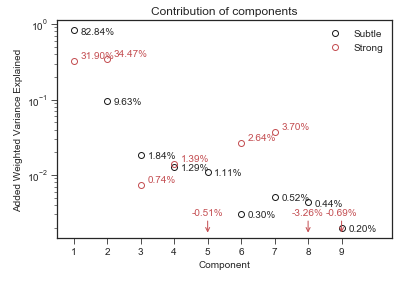

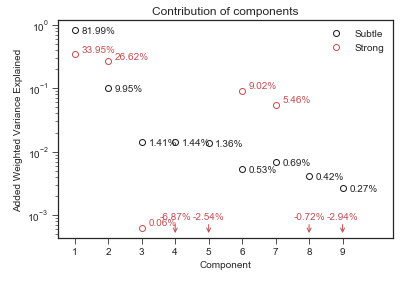

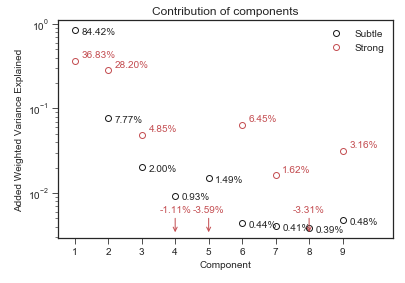

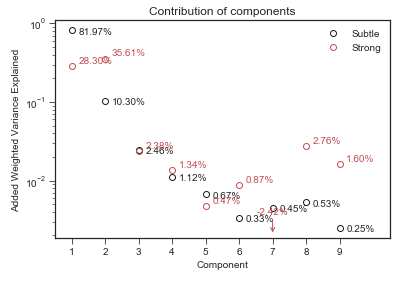

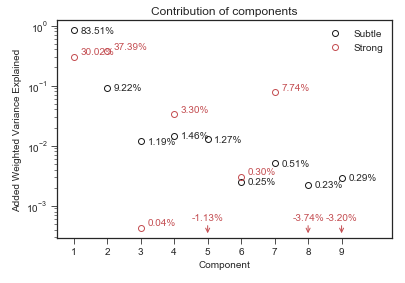

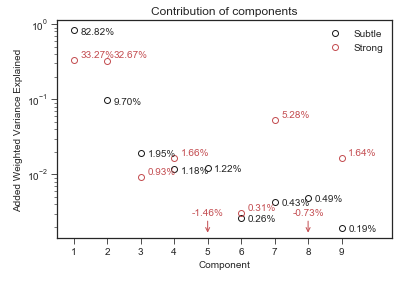

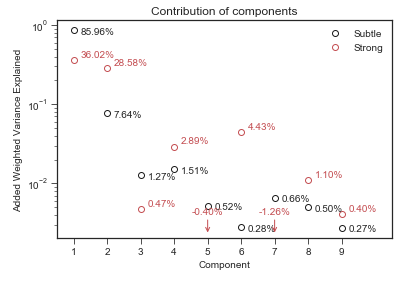

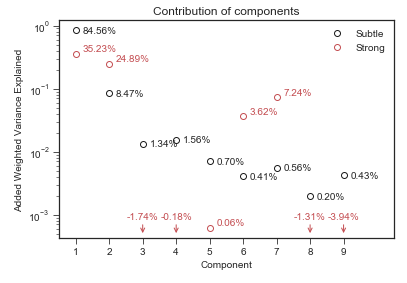

In [9]:
for i in range(n_trials):
    
    dataset = datasets[i]
    n_perms = 100
    weighted= True
    ymax = 1.0
    ymin = -1.0

    all_guesses = dataset['CV_all_guesses']
    both_old = dataset['both_old']
    dhats = dataset['dhats']
    this_fitness  = dataset['this_fitness']
    train  = dataset['train']
    test = dataset['test']
    both_new = dataset['both_new']
    guesses = dataset['guesses']
    model = dataset['CV_best_rank_index']
    test_conditions  = dataset['test_conditions']

    nonsubtle_fits = []
    subtle_fits = []
    overall_subtle = []
    overall_nonsubtle = []
    for model in range(20):
        # this_gene_data = this_data[this_data['barcode'].isin(test_mutant_data)]
        types = this_data[this_data['barcode'].isin(dataset['testing_bcs'])]['mutation_type'].values

        new_mut_locs = dataset['mut_locs'][model][test[1]]

        old_cond_locs = dataset['cond_locs'][model][train[0]]

        new_cond_locs = dataset['cond_locs'][model][test[0]]

        these_sigmas = dataset['dimension_weights'][model]
        these_sigmas = these_sigmas[:model+1,:model+1]

#         plt.figure()
#         plt.scatter(this_fitness[test[1],-1],np.dot(new_mut_locs,np.dot(these_sigmas,new_cond_locs.T))[:,-1])


        overall_nonsubtle.append(tools.var_explained_weighted_by_type(this_fitness[test[1],:][:,test[0]],
                                                                      np.dot(new_mut_locs,np.dot(these_sigmas,new_cond_locs.T)),types)[0])

        this_sse = np.asarray([tools.var_explained_weighted_by_type(this_fitness[test[1],test[0][i]],
                                                                      np.dot(new_mut_locs,np.dot(these_sigmas,new_cond_locs.T))[:,i],types)[0] for i in range(new_cond_locs.shape[0])])
        nonsubtle_fits.append(this_sse)

        overall_subtle.append(tools.var_explained_weighted_by_type(this_fitness[test[1],:][:,train[0]],
                                                                      np.dot(new_mut_locs,np.dot(these_sigmas,old_cond_locs.T)),types)[0])


        subtle_sse = np.asarray([tools.var_explained_weighted_by_type(this_fitness[test[1],train[0][i]],
                                                                      np.dot(new_mut_locs,np.dot(these_sigmas,old_cond_locs.T))[:,i],types)[0] for i in range(old_cond_locs.shape[0])])


        subtle_fits.append(subtle_sse)
    
    end = 8
    
    plt.figure() 
    plt.plot([overall_subtle[0]]+list(np.diff(overall_subtle))[:end],'o',markeredgecolor='k',markerfacecolor='None',label='Subtle')
    plt.ylabel('Added Weighted Variance Explained')
    # plt.yscale('log',basey=10)

    for i,item in enumerate([overall_subtle[0]]+list(np.diff(overall_subtle))[:end]):
    #     plt.annotate(xy=(i+0.2,item+0.0*item),s=f'{item*100:.2f}% ({overall_subtle[i]*100:.2f}%)',transform=plt.gca().transAxes)
        plt.annotate(xy=(i+0.2,item-0.1*item),s=f'{item*100:.2f}%',transform=plt.gca().transAxes)

    plt.plot([overall_nonsubtle[0]]+list(np.diff(overall_nonsubtle))[:end],'o',markeredgecolor='r',markerfacecolor='None',label='Strong')
    plt.ylabel('Added Weighted Variance Explained')
    plt.yscale('log',basey=10)
    plt.xticks(range(len(overall_subtle[:end+1])),range(1,len(overall_subtle[:end+1])+1))
    plt.xlabel('Component')

    for i,item in enumerate([overall_nonsubtle[0]]+list(np.diff(overall_nonsubtle))[:end]):
    #     plt.annotate(xy=(i+0.2,item+0.0*item),s=f'{item*100:.2f}% ({overall_subtle[i]*100:.2f}%)',transform=plt.gca().transAxes)
        plt.annotate(xy=(i+0.2,item+0.1*item),s=f'{item*100:.2f}%',transform=plt.gca().transAxes,color='r')


    ymin,ymax = plt.ylim()
    for i,item in enumerate([overall_nonsubtle[0]]+list(np.diff(overall_nonsubtle))[:end]):
        if item < 0:
            plt.annotate(xytext=(i,2*ymin),xy=(i,ymin+0.1*ymin),s=f'{item*100:.2f}%',transform=plt.gca().transAxes,color='r',
                         ha='center',arrowprops=dict(arrowstyle='->',color='r'))
#             plt.annotate(xytext=(i,2*ymin),xy=(i,ymin+0.1*ymin),s="",transform=plt.gca().transAxes,color='r',
#                  ha='center',arrowprops=dict(arrowstyle='->',color='r'))

    #     plt.annotate(xy=(i+0.2,item+0.0*item),s=f'{item*100:.2f}% ({overall_subtle[i]*100:.2f}%)',transform=plt.gca().transAxes)

    plt.xlim(-0.5,end+1.5)
    plt.title('Contribution of components')
    plt.legend()
    